# Immune cell types mass
This notebook load the literature estimates for the single cell mass of various immune cell types. It than plot them (Figure S6) and aggregate them into a a total estimate. Than save it to a csv to be used later

### Importing

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap
import scipy.stats as stats
from scipy.stats import gmean, norm, lognorm

### For figures

In [2]:
save_dir = "Figures"
mpl.style.use("seaborn")
sns.set_style("whitegrid")
rc_pars = {
    "legend.facecolor": "white",
    "legend.framealpha": 0.85,
    "lines.linewidth": 1.5,
    "legend.edgecolor": "Black",
    "legend.frameon": True,
    "legend.fancybox": True,
    "legend.shadow": False,
}

inc_to_cm = 2.54
fig_inches = {
    "small": [np.round(9/inc_to_cm,1), np.round(6/inc_to_cm,1)],
    "medium": [np.round(11/inc_to_cm,1), np.round(11/inc_to_cm,1)],
    "large": [np.round(18/inc_to_cm,1), np.round(22/inc_to_cm,1)],
    }

fig_dpi = {
    "small": 300,
    "medium": 300,
    "large": 600,
    }

font_sizes = {
    "small": {'label': 9, 'title':10},
    "medium": {'label': 6.7, 'title':7.8},
    "large": {'label': 10, 'title':11},
    }

grid_lw = {
    "small": 0.3,
    "medium": 0.5,
    "large": 0.75,
    }

def set_rc_params(fig_size="medium"):
    rc_pars.update(
        {
            "figure.figsize": fig_inches[fig_size],
            "figure.dpi": fig_dpi[fig_size],
            "axes.labelsize": font_sizes[fig_size]['title'],
            "xtick.labelsize": font_sizes[fig_size]['label'],
            "font.size": font_sizes[fig_size]['title'],
            "ytick.labelsize": font_sizes[fig_size]['label'],
            "axes.titlesize": font_sizes[fig_size]['title'],
            "legend.title_fontsize": font_sizes[fig_size]['label']*0.9,
            "legend.fontsize": font_sizes[fig_size]['label']*0.9,
            'grid.linewidth': grid_lw[fig_size]
        }
    )
    plt.rcParams["figure.figsize"] = rc_pars["figure.figsize"]
    plt.rcParams["figure.dpi"] = rc_pars["figure.dpi"]
    plt.rcParams["legend.fontsize"] = rc_pars["legend.fontsize"]
    sns.set_context("talk", rc=rc_pars)


# Small: approximately 9 cm x 6 cm
# Medium: approximately 11 cm x 11 cm
# Large: approximately 18 cm x 22 cm

C:\Users\Ron Sender\AppData\Local\Temp\ipykernel_17636\4136828032.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  mpl.style.use("seaborn")


The color scheme for cell types:

In [3]:
hue = 0.9
lymphs = ["T cells", "B cells", "Plasma cells", "NK cells"]
pr_pl = sns.cubehelix_palette(
    start=0.1,
    rot=0.4,
    dark=0.28,
    light=0.85,
    reverse=True,
    as_cmap=False,
    n_colors=len(lymphs),
    hue=hue,
).as_hex()
grans = [
    "Mast cells",
    "Neutrophils",
    "Eosinophils",
    "Basophils",
]
bl_pl = sns.cubehelix_palette(
    start=3.2,
    rot=-0.32,
    dark=0.2,
    light=0.75,
    reverse=True,
    as_cmap=False,
    n_colors=len(grans),
    hue=hue,
).as_hex()
myes = ["Macrophages", "Monocytes", "Dendritic cells"]
gr_pl = sns.cubehelix_palette(
    start=2.55,
    rot=-0.33,
    dark=0.25,
    light=0.75,
    reverse=True,
    as_cmap=False,
    n_colors=len(myes),
    hue=hue,
).as_hex()
ct_color_dict = dict(zip(lymphs + grans + myes, pr_pl + bl_pl + gr_pl))
cell_type_order = list(ct_color_dict.keys())
cell_type_colors = list(ct_color_dict.values())

### Loading the immune cell type mass data

In [4]:
data_dir = "Data/Literature data"
res_dir = "Data/Interim results"
fname = 'density_data.xlsx'
f_path = f"{data_dir}/{fname}"
mass_df = pd.read_excel(f_path, sheet_name='Mass')
mass_df.cell_type = mass_df.cell_type.map(lambda ct: ct + 's' if ct[-1]!='s' else ct)

Adding columns for the figures

In [5]:
ct_for_fig = ['Lymphocytes', 'Plasma cells', 'Granulocytes'] + grans + myes
ct_color_dict.update({'Lymphocytes': ct_color_dict['T cells'], 'Granulocytes':ct_color_dict['Neutrophils']})
mass_df.cell_type = mass_df.cell_type.astype("category")
mass_df.cell_type = mass_df.cell_type.cat.set_categories(ct_for_fig)
mass_df = mass_df.sort_values('cell_type')
mass_df['color'] = mass_df.cell_type.map(ct_color_dict)


In [6]:
def jitter(values,j):
    return values + np.random.normal(j,0.075,values.shape)

type_ids = dict(zip(mass_df.cell_type.unique(), range(mass_df.cell_type.nunique())))
mass_df["x_jitter"] = jitter(mass_df.cell_type.map(type_ids).astype(int), 0)

In [7]:
wrapper = textwrap.TextWrapper(20)
mass_df.tissue = mass_df.tissue.map(lambda s: wrapper.fill(s) if type(s)== str else np.nan)

In [8]:
'''
This function get the axes of a subplots figure and put labels
---
axes - a list of axes of the figure
letter_labels - a list of labels to be put on the subplots
x_left - the horizontal indentation of the label
y_up - the horizontal indentation of the label
'''

def put_panel_labels(axes,  letter_labels=list('ABCDEF'), x_left=-0.12, y_up=1.1):
    for i, ax in enumerate(axes):
        ax.text(x_left, y_up, letter_labels[i], transform=ax.transAxes, fontsize=11, va='top', ha='right')

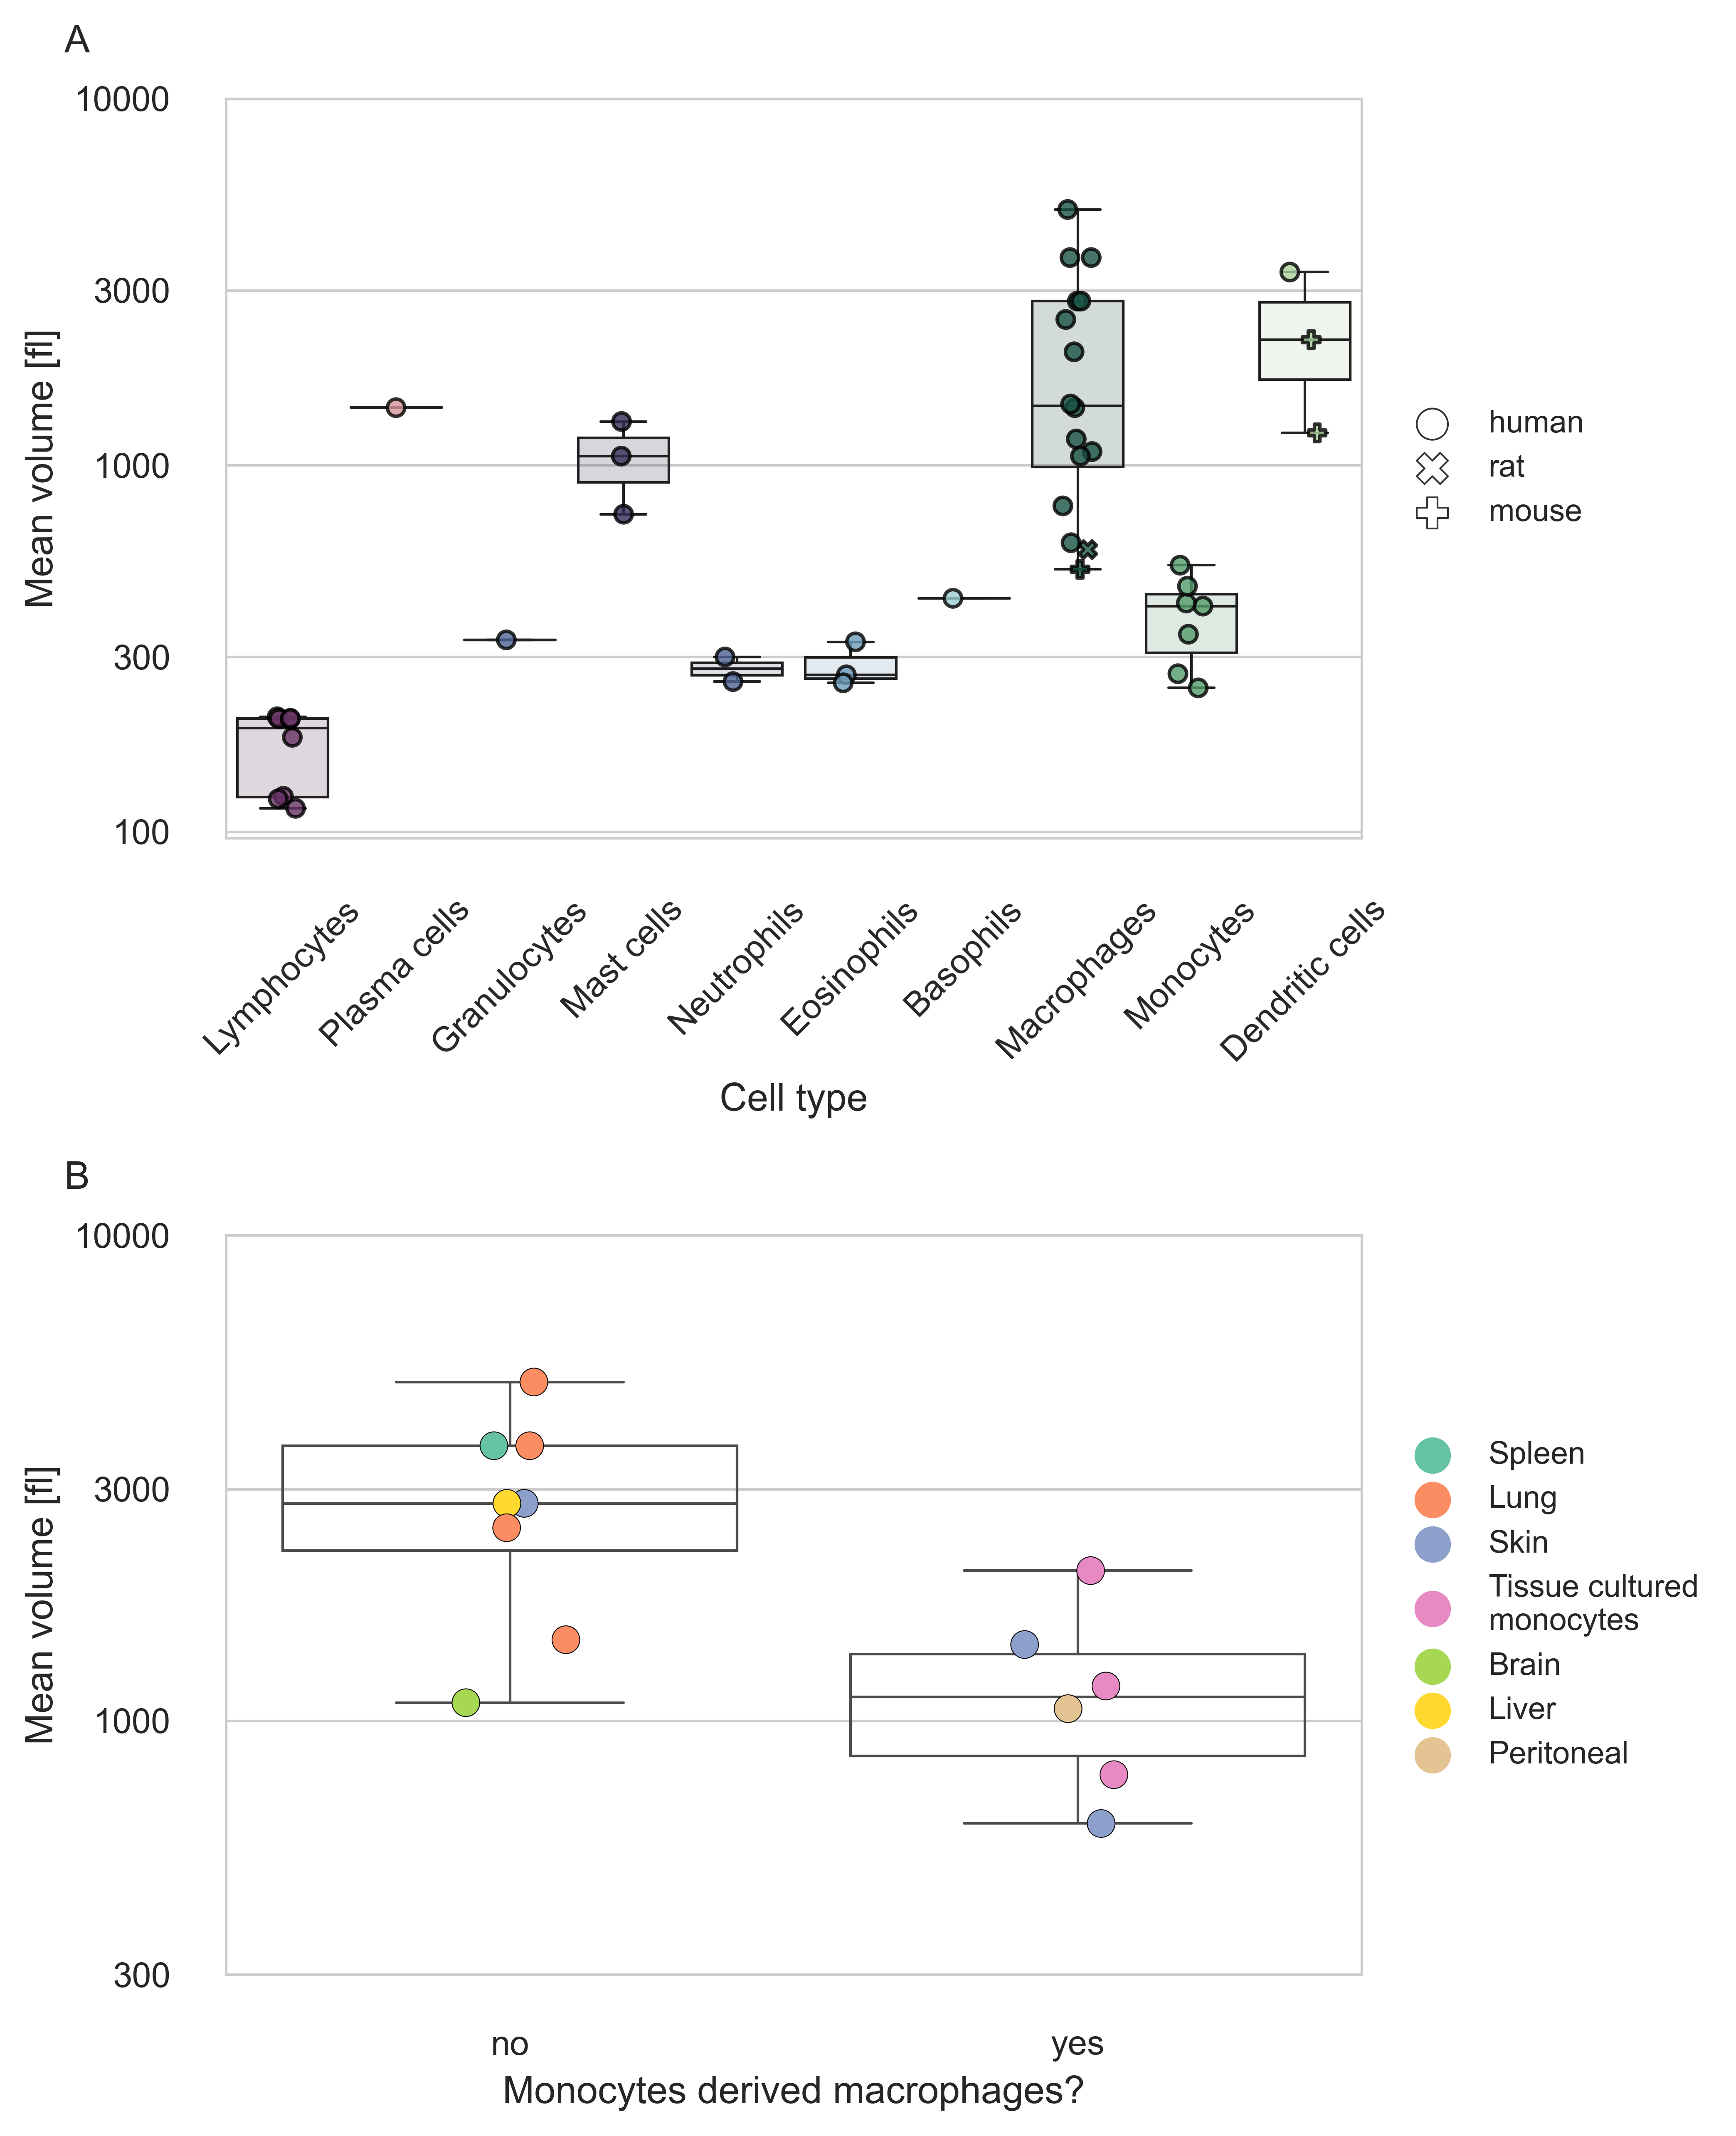

In [9]:
set_rc_params("large")
fig, axes = plt.subplots(2, 1)
# fig.set_size_inches(12, 14)
put_panel_labels(axes)
ax = axes[0]
sns.scatterplot(
    data=mass_df,
    x="x_jitter",
    y="mean_volume_fl",
    style="specie",
    s=25,
    edgecolor="k",
    linewidth=1,
    ax=ax,
    zorder=5,
    c=mass_df.color,
    alpha=0.8,
    markers={"human": "o", "mouse": "P", "rat": "X"},
)
sns.boxplot(
    data=mass_df,
    x="cell_type",
    y="mean_volume_fl",
    ax=ax,
    palette=ct_color_dict,
    linewidth=0.75,
)
ax.set_yscale("log")
y_ticks = [100, 300, 1000, 3000, 10000]

ax.set_yticks(y_ticks, y_ticks)
ax.set_xticks(
    ax.get_xticks(),
    labels=type_ids.keys(),
    rotation=45,
)
for patch in ax.patches:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, 0.2))

hands, labs = ax.get_legend_handles_labels()
for h in hands:
    h.set_facecolor("none")
    h.set_linewidth(0.5)
ax.legend(bbox_to_anchor=(1.01, 0.5), loc="center left")
ax.set_ylabel("Mean volume [fl]")
ax.set_xlabel("Cell type")
for side in ['top', 'bottom', 'left', 'right']:
    ax.spines[side].set(lw=0.75)


human_mac_df = mass_df[
    (mass_df.cell_type == "Macrophages") & (mass_df.specie == "human")
]
ax = axes[1]
sns.stripplot(
    data=human_mac_df,
    x="monocyte_derived_mac",
    y="mean_volume_fl",
    hue="tissue",
    s=8,
    palette="Set2",
    edgecolor="k",
    linewidth=0.25,
    ax=ax,
)
sns.boxplot(
    data=human_mac_df,
    x="monocyte_derived_mac",
    y="mean_volume_fl",
    ax=ax,
    linewidth=0.75,
)
ax.set_yscale("log")

for side in ['top', 'bottom', 'left', 'right']:
    ax.spines[side].set(lw=0.75)
y_ticks = [300, 1000, 3000, 10000]
ax.set_yticks(y_ticks, y_ticks)
for patch in ax.patches:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, 0.0))
ax.legend(bbox_to_anchor=(1.01, 0.5), loc="center left")
ax.set_ylabel("Mean volume [fl]")
ax.set_xlabel("Monocytes derived macrophages?")
fig.tight_layout()
fig.savefig(f"{save_dir}/Figure_S6.pdf", dpi=rc_pars["figure.dpi"])

### Fuctions for aggregation
Same as in the density calculation notebook. Mainly for dealing with logarithmic uncertainty

In [10]:
def gmean_w_nulls(arr):
    return np.exp(np.mean(np.log(arr)))

def mult_unc_for_arr(arr):
    non_nans = np.sum(1 - np.isnan(arr))
    if non_nans == 0:
        return np.nan
    elif non_nans == 1:
        return 1
    else:
        return np.exp((np.log(arr)).sem())

def err_add_to_mul(val_arr, err_arr):
    return ((val_arr + err_arr)/(val_arr - err_arr))**0.5

def unc_fac_cal(val_arr, err_arr, err_additive=True):
    means_var_fac = mult_unc_for_arr(val_arr)
    if err_additive:
        sems_var_fac = gmean_w_nulls(err_add_to_mul(val_arr, err_arr))
    else:
        sems_var_fac = gmean_w_nulls(err_arr)
    return np.exp(np.sqrt(np.square(np.log(means_var_fac)) + np.square(np.log(sems_var_fac))))



Dropping lower than 150 fl estimates for lymphocytes as they were measured in an unrealiable method. Then using pivot table to summarize the volume per cell

In [11]:
mass_df = mass_df[
    ~(mass_df.cell_type.eq("Lymphocytes") & mass_df.mean_volume_fl.lt(150))
]
ct_mass = mass_df.pivot_table(
    index="cell_type",
    values="mean_volume_fl",
    aggfunc=gmean_w_nulls,
)
for gr in ["Basophils", "Neutrophils", "Eosinophils"]:
    tmp_df = mass_df[mass_df.cell_type == "Granulocytes"].copy()
    tmp_df.cell_type = gr
    mass_df = pd.concat([mass_df, tmp_df],ignore_index=True)

In [12]:
ct_mass = mass_df.pivot_table(index='cell_type', values='mean_volume_fl', aggfunc=gmean_w_nulls)
mass_df.loc[mass_df.sem_volume_fl.isnull(), 'sem_volume_fl'] = mass_df.loc[mass_df.sem_volume_fl.isnull(), 'std_volume_fl']
ct_mass['mean_volume_err'] = mass_df.groupby(['cell_type']).apply(lambda row: unc_fac_cal(val_arr=row.mean_volume_fl, err_arr=row.sem_volume_fl, err_additive=True))
ct_mass

mean_volume_fl  mean_volume_err
cell_type                                       
Basophils            380.604557         1.181875
Dendritic cells     2087.094919         1.482613
Eosinophils          294.609139         1.110705
Granulocytes         334.000000         1.039909
Lymphocytes          199.339846         1.043328
Macrophages         1553.109339         1.360597
Mast cells          1008.824323         1.395274
Monocytes            372.901152         1.114652
Neutrophils          295.302381         1.083387
Plasma cells        1436.755040         1.967121

In [13]:
mac_mass_by_tiss = human_mac_df.pivot_table(index=['tissue'], values='mean_volume_fl', aggfunc=gmean_w_nulls)
human_mac_df.loc[human_mac_df.sem_volume_fl.isnull(), 'sem_volume_fl'] = human_mac_df.loc[human_mac_df.sem_volume_fl.isnull(), 'std_volume_fl']
mac_mass_by_tiss['mean_volume_err'] = human_mac_df.groupby(['tissue']).apply(lambda row: unc_fac_cal(val_arr=row.mean_volume_fl, err_arr=row.sem_volume_fl, err_additive=True))

mac_mass_by_mo_der =  human_mac_df.pivot_table(index=['monocyte_derived_mac'], values='mean_volume_fl', aggfunc=gmean_w_nulls)
mac_mass_by_mo_der['mean_volume_err'] = mass_df.groupby(['monocyte_derived_mac']).apply(lambda row: unc_fac_cal(val_arr=row.mean_volume_fl, err_arr=row.sem_volume_fl, err_additive=True))
mac_mass_by_mo_der = mac_mass_by_mo_der.rename({'no': 'non mono derived', 'yes': 'mono derived'})
mac_mass = pd.concat([mac_mass_by_tiss, mac_mass_by_mo_der])

In [14]:
mac_mass =mac_mass.rename({'Lung': 'Lungs',
                           'Peritoneal': 'Connective tissue'})

In [15]:
monocyte_replenished_tissues = ['Skin', 'Connective tissue', 'Stomach', 'Colon', 'SI']
def mac_cell_mass(tiss):
    if tiss in mac_mass.index:
        return mac_mass.loc[tiss]
    elif tiss in monocyte_replenished_tissues:
        return mac_mass.loc['mono derived']
    else:
        return mac_mass.loc['non mono derived']

Lymphocytes_ct = ['T cells', 'B cells', 'NK cells']
def add_cell_type_mass(ct, tiss):
    if ct == 'Macrophage':
        return mac_cell_mass(tiss)
    elif ct in ct_mass.index:
        return ct_mass.loc[ct]
    elif ct[:-1] in ct_mass.index:
        return ct_mass.loc[ct[:-1]]
    elif f"{ct}s" in ct_mass.index:
        return ct_mass.loc[f"{ct}s"]
    elif ct in Lymphocytes_ct:
        # return ct_mass.loc['Lymphocyte']
        return ct_mass.loc['Lymphocytes']

In [16]:
mac_mass

mean_volume_fl  mean_volume_err
Brain                          1090.322581         1.500000
Liver                          2806.162188         1.243163
Lungs                          2867.877731         1.390492
Connective tissue              1059.912951         1.067490
Skin                           1353.371935         1.675198
Spleen                         3688.795993         1.664290
Tissue cultured\nmonocytes     1231.037528         1.346483
non mono derived               2608.335567         1.490117
mono derived                   1097.413928         1.267612

### Integrating with the tissue immune cell density estimate
Saving to a csv file

In [17]:
dens_df = pd.read_csv(f'{res_dir}/density_by_ct_tiss.csv', index_col=0)
dens_df = dens_df.join(dens_df.apply(lambda rw: add_cell_type_mass(rw.cell_type, rw.tissue), axis=1))

In [18]:
dens_df.to_csv(f'{res_dir}/density_by_ct_tiss_w_mass.csv')

### Aggragation to total mass estimates

Defining aggregation functions

In [19]:
def unc_of_mul(unc_facs_arr):
    log_unc_facs = np.log(unc_facs_arr)
    return np.exp((log_unc_facs**2).sum(axis=1)**0.5)


def error_linear_to_mul(val_arr, err_arr):
    return gmean([1/(1-err_arr/val_arr), 1 + err_arr/val_arr])


'''
arr - array 3xn with row for each value added. Each with mean, uncertainty type and uncertainty factor
'''
def unc_of_add(arr, n_iterations=1000):
    n_var = arr.shape[0]
    if n_var == 1:
        if arr[0, 1] == 'linear':
            return error_linear_to_mul(arr[0, 0], arr[0, 2])
        else:
            return arr[0, 2]
    else:
        # print(arr)
        dists = [norm(arr[i, 0], arr[i, 2]) if arr[i, 1] == 'linear' else lognorm(scale=arr[i, 0], s=np.log(arr[i, 2]) +0.0001)  for i in range(arr.shape[0])]
        x = np.zeros([n_iterations, n_var])
        for i in range(arr.shape[0]):
            dist = norm(arr[i, 0], arr[i, 2]) if arr[i, 1] == 'linear' else lognorm(scale=arr[i, 0], s=np.log(arr[i, 2])+0.0001)
            # print(dist.kwds)
            x[:, i] = dist.rvs(n_iterations)
        fit_params = lognorm.fit(x.sum(axis=1), floc=0)
        return np.exp(fit_params[0])
def agg_tissue_group_simple(df, cols=['total_ext', 'total_ext_err']):
    output = pd.Series(dtype=float, index=cols)
    df2 = df.loc[~df[cols[0]].isnull()]
    if df2.shape[0]>0:
        output[cols[0]] = df2[cols[0]].sum()
        df2['unc_type'] = 'mul'
        output[cols[1]] =  unc_of_add(df2[[cols[0], 'unc_type', cols[1]]].values)
    return output

Estimating the total mass by aggregating on the tissues. Then saving to an xlsx file

In [20]:
dens_df['total'] =  dens_df.density * dens_df.mass
dens_df['total_mass'] = dens_df.total * dens_df.mean_volume_fl * 1.07 /10**12
dens_df['total_mass_err'] = unc_of_mul(dens_df[['err','mean_volume_err']])


In [21]:
dens_df = dens_df[dens_df.total_mass>0]

In [22]:
summ_temp = pd.read_csv(f'{res_dir}/Summary_immune_cells.csv',index_col=0).loc['Total_cells'].reset_index(drop=True)
summ_temp = summ_temp.drop(columns=['cell_type_family']).set_index('cell_type')

In [29]:
temp_mass_df = dens_df.groupby(["cell_type", "for_final_table"]).apply(
    lambda df: agg_tissue_group_simple(df, cols=["total_mass", "total_mass_err"])
)

piv_mass = temp_mass_df.reset_index().pivot_table(
    index="cell_type",
    columns="for_final_table",
    values="total_mass",
    aggfunc=lambda x: np.round(x, decimals=1),
)
piv_mass = piv_mass[summ_temp.columns] 
piv_mass = piv_mass.loc[summ_temp.index] 

piv_err = temp_mass_df.reset_index().pivot_table(
    index="cell_type",
    columns="for_final_table",
    values="total_mass_err",
    aggfunc=lambda x: np.round(x, decimals=2),
)
piv_err = piv_err[summ_temp.columns] 
piv_err = piv_err.loc[summ_temp.index] 

fname = f'{res_dir}/total_mass.xlsx'
with pd.ExcelWriter(fname) as writer:
    piv_mass.loc[summ_temp.index, summ_temp.columns].to_excel(writer, sheet_name='Total_mass')
    piv_err.loc[summ_temp.index, summ_temp.columns].to_excel(writer, sheet_name='Total_mass_unc')